In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
import os
import cv2
from matplotlib.pyplot import figure, draw, pause, gca
%matplotlib inline

In [2]:
def convolution2D(image,filter_):
    if len(image.shape) > 2:
        raise Exception('Make sure you pass a grayscale image')
    
    if len(filter_.shape) > 2:
        raise Exception('Make sure you pass a 2D image')
    
    H,W = image.shape
    filter_H,filter_W = filter_.shape
    
    pad = int(filter_H / 2)
    image = np.pad(image,pad,mode='reflect')    
    im = np.zeros((H,W))
   
    for y in np.arange(pad, H + pad):
        for x in np.arange(pad, W + pad):
            region_of_interest = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
            # sigma of cross relation between filter and region of interest
            
            value = (region_of_interest * filter_).sum()
            im[y - pad][x - pad] = value
    
    return im

dx = np.array([[1.0, 0.0, -1.0],[2.0, 0.0, -2.0],[1.0, 0.0, -1.0]])
dy = np.transpose(dx)

def create_quiver_plot(U,V,image1,subsample=6):
    Hu,Wu = U.shape
    Hv,Wv = V.shape
    # Subsample the vector field to make it less dense
    sub_u = U[0:Wu-1:subsample, 0:Hu-1:subsample]
    sub_v = V[0:Wv-1:subsample, 0:Hv-1:subsample]
    xc = np.linspace(0, Wu-1, sub_u.shape[1])
    yc = np.linspace(0, Hu-1, sub_u.shape[0])
    # Locations of the vectors
    xv, yv = np.meshgrid(xc, yc)
    
    fig2 = plt.figure(figsize = (14,7))
    plt.imshow(U**2+V**2,cmap='viridis')
    plt.plot()
    
    fig1 = plt.figure(figsize = (14,7))
    plt.imshow(image1,cmap = 'gray')
    plt.title('Optical Flow'), plt.xticks([]), plt.yticks([])
    # Plot the vectors
    plt.quiver(xv, yv, sub_u, sub_v, color='y')
    plt.plot()

# Optical Flow Methods

In [3]:
def get_image(im_path):
    return cv2.imread(im_path,0)

In [4]:
sphere1 = get_image('sphere0.png')
sphere2 = get_image('sphere1.png') 
traffic1 = get_image('traffic0.png')
traffic2 = get_image('traffic1.png')

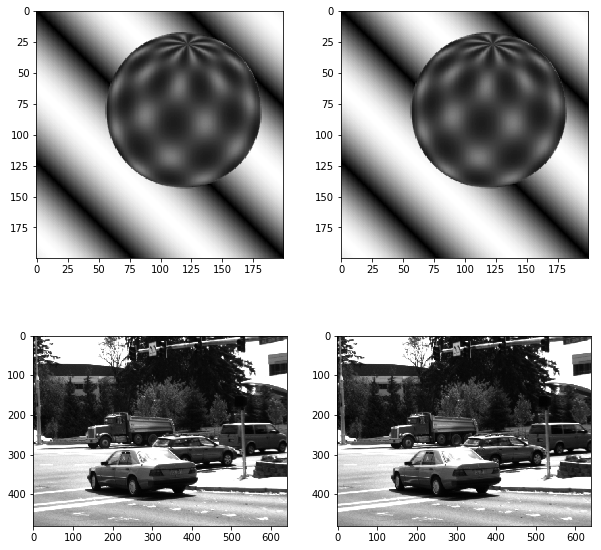

In [5]:
# Show the original image

fig1 = plt.figure(figsize = (10,10))
for i,image in zip(range(4),[sphere1,sphere2,traffic1,traffic2]):
    plt.subplot(2,2,i+1)
    plt.imshow(image,cmap='gray')
plt.show()

Implementation outline for lucas-kanade and Horn-Schunck method: 
* Assume two images with same dimensions im1 and im2
* Compute Spatial Derivative images Ix and Iy for im1 using any method of your choice. 
* Compute temporal partial derivative It. This can be approximated by image difference im2 - im1

# Lucas-Kanade

* This method solves for optical flow by assuming constant flow within a neighborhood (patch), centered around the current pixel (i,j). 
* Using this assumption, a linear system is constructed and solved to find u i,j and v i,j . 
* This means you must repeat this process for every pixel in the image.
* Consider using a neighborhood size of 5x5. This results in the linear system shown below, with a matrix= consisting of spatial partial derivatives and a vector of temporal partial derivatives at all points in the neighborhood p i . 
* Solve this system of equations via linear least squares to find u i,j and v i,j
* You may ignore the boundary of the image where you cannot sample a full neighborhood.

In [6]:
def lucas_kanade(im1, im2,window):
    w = window // 2
    
    im1 = im1.astype(np.float32)
    im2 = im2.astype(np.float32)

    # set up initial velocities
    U = np.zeros([im1.shape[0], im1.shape[1]])
    V = np.zeros([im1.shape[0], im1.shape[1]])

    # Estimate derivatives
    fx, fy, ft = get_derivatives(im1, im2)
    
    for i in range(w,im1.shape[0]-w):
        for j in range(w,im2.shape[1]-w):
            # compute Ix, Iy and It for the given window
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            
            # get matrices to form equations. For window 5: A should be 25x2, B 25x1
            B = np.expand_dims(-It,1) 
            A = np.concatenate([np.expand_dims(Ix,1),np.expand_dims(Iy,1)],axis=1)
            
            # solve using least squares
            U[i,j],V[i,j] = np.linalg.lstsq(A,B)[0]
    return U, V


def get_derivatives(im1, im2):
    fx = convolution2D(im1, dx) + convolution2D(im2, dx)
    fy = convolution2D(im1, dy) + convolution2D(im2, dy)
    ft = im2 - im1

    return fx, fy, ft

/home/omkar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


***********
***********
***********
***********


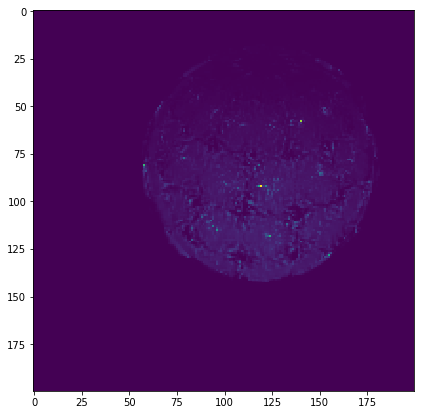

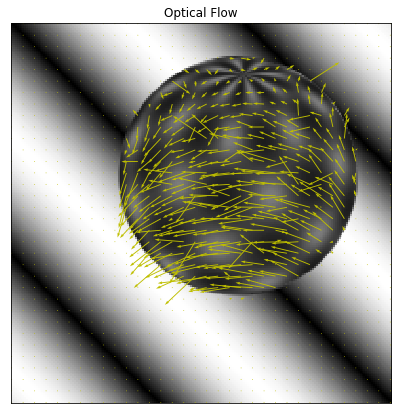

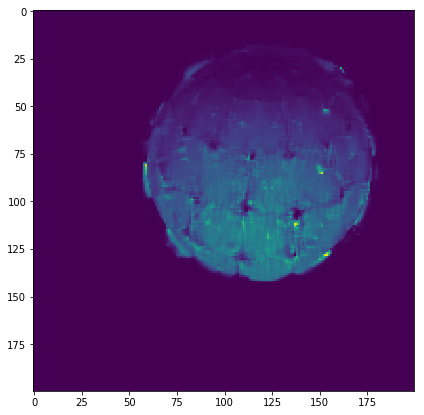

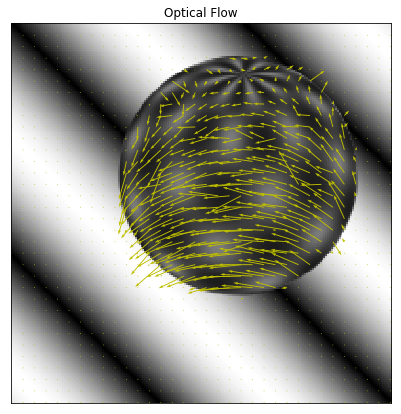

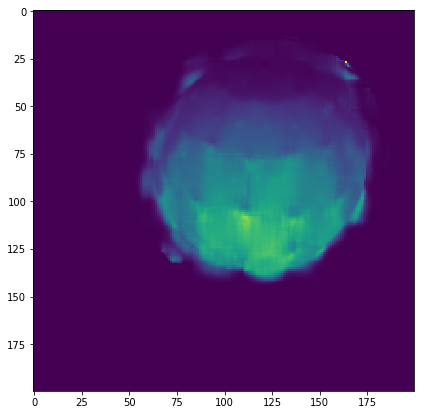

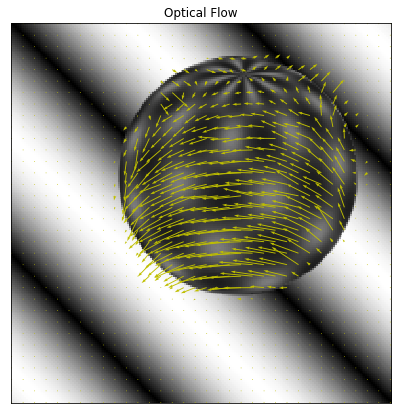

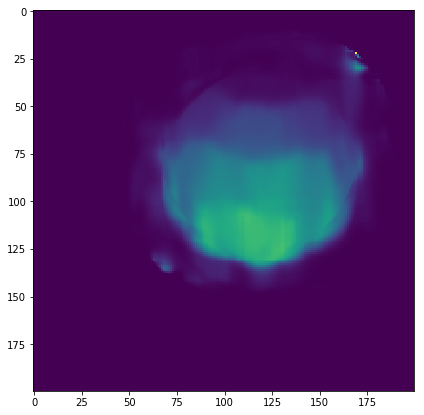

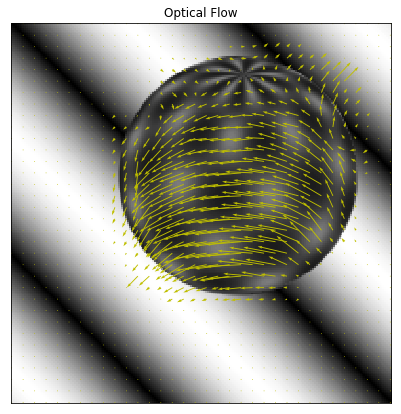

In [39]:
# magnitude
for window in [3,5,11,21]:
    U,V = lucas_kanade(sphere1,sphere2,window=window)
    create_quiver_plot(U,V,sphere1)
    print('***********')

/home/omkar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


***********
***********
***********
***********


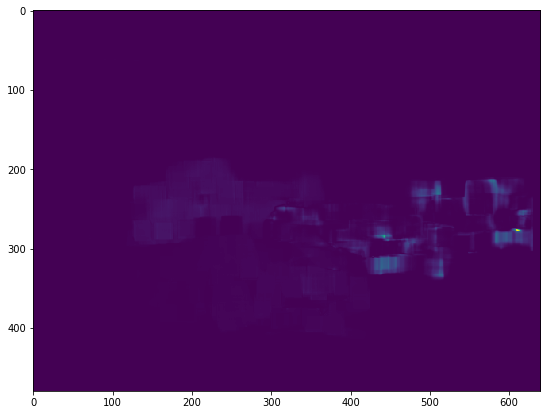

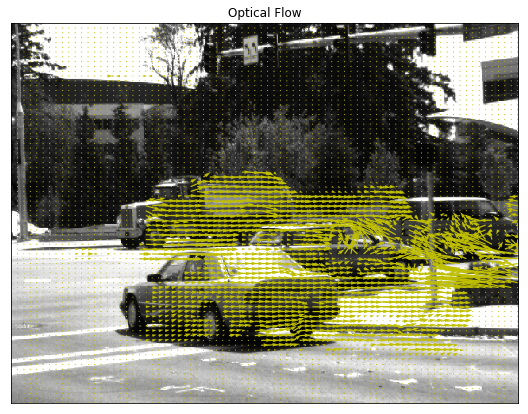

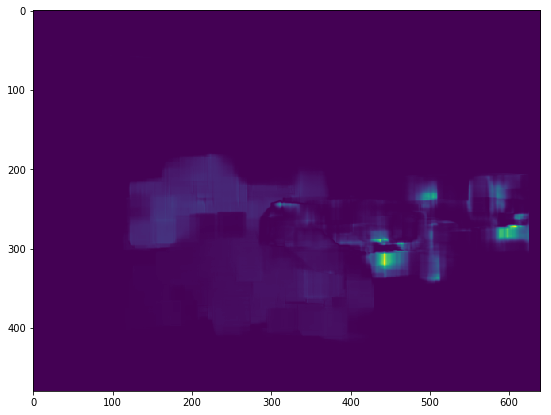

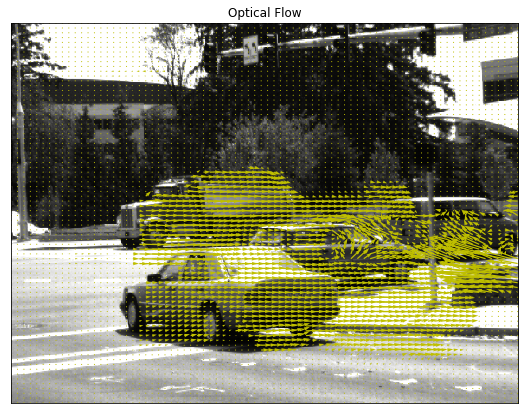

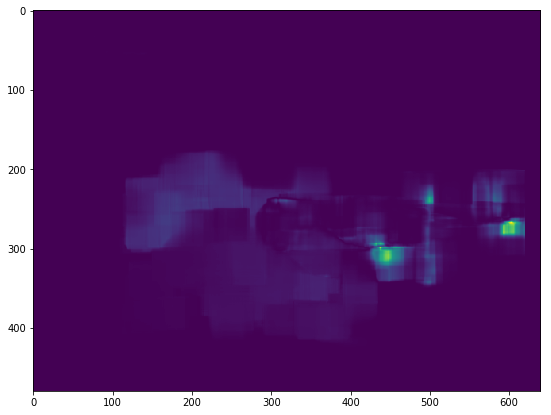

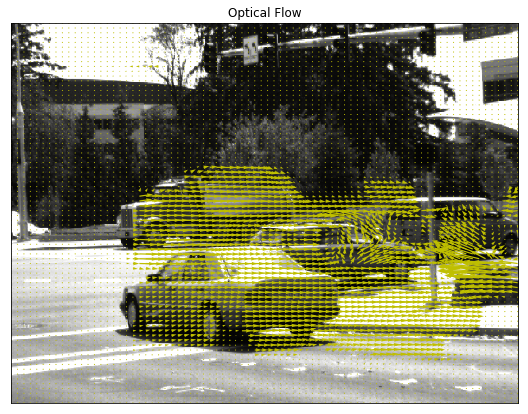

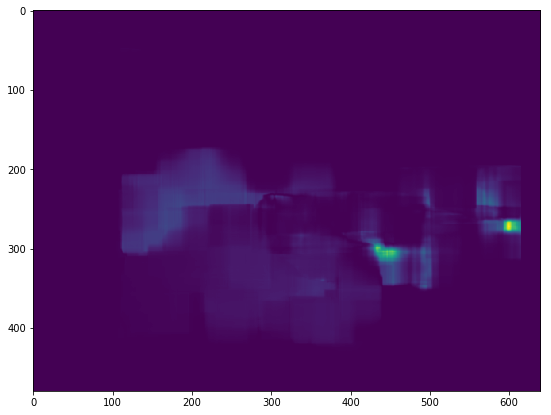

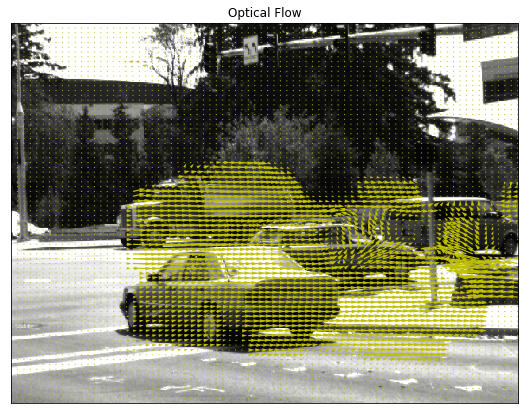

In [12]:
for window in [21,31,41,51]:
    U,V = lucas_kanade(traffic1,traffic2,window=window)
    create_quiver_plot(U,V,traffic1)
    print('***********')

# Horn Schunck 

In [7]:
import math
def create_gaussian_filter(sigma):
    n = 2*math.floor(3*sigma)+1
    
    # Create a blank filter nxn
    filter_out = np.zeros((n,n))
    
    # These are the points (x,y) we want to sample our function f(x,y)
    # This also centers our sampling in the middle of the filter
    # They don't necessarily need to correspond to integer indices of the array
    x_sampling = np.linspace(-n/2, n/2, n)
    y_sampling = np.linspace(-n/2, n/2, n)
    # If you want integer sampling use
    x_sampling = np.linspace(-(n-1)/2, (n-1)/2, n)
    y_sampling = np.linspace(-(n-1)/2, (n-1)/2, n)
   
    # Fill in the filter
    constant = 1 / (2*math.pi*(sigma**2))
    
    for x in range(0, len(x_sampling)):
        for y in range(0, len(y_sampling)):
            
            # Sample the function at our precomputed sampling locations
            filter_out[x][y] = constant * math.exp(-(x_sampling[x]**2+y_sampling[y]**2)/(2*(sigma**2)))
            
    # Normalize the filter (sum to 1
    return filter_out

In [8]:
gauss = create_gaussian_filter(0.5)

In [9]:
def horn_schunck(im1, im2,alpha= 0.001, iter_ = 8):
    # get averaging kernel
    avg_kernel = np.array([[1/12, 1/6, 1/12],
                           [1/6,    0, 1/6],
                           [1/12, 1/6, 1/12]], float)

    im1 = im1.astype(np.float32)
    im2 = im2.astype(np.float32)

    # set up initial velocities
    U = np.zeros([im1.shape[0], im1.shape[1]])
    V = np.zeros([im1.shape[0], im1.shape[1]])

    # Estimate derivatives
    fx, fy, ft = get_derivatives(im1, im2)

    
    # Iteration to reduce error
    for iteration in range(iter_):
        
        # Compute local averages of the flow vectors
        uAvg = convolution2D(U, avg_kernel)
        vAvg = convolution2D(V, avg_kernel)

        # common part of update step
        der = (fx*uAvg + fy*vAvg + ft) / (alpha**2 + fx**2 + fy**2)

        # iterative step update
        U = uAvg - fx * der
        V = vAvg - fy * der

    return U, V


def get_derivatives(im1, im2):
    fx = convolution2D(im1, dx) + convolution2D(im2, dx)
    fy = convolution2D(im1, dy) + convolution2D(im2, dy)
    ft = im2 - im1
    return fx, fy, ft

Horn Schunck for alpha:  100
******************************
Horn Schunck for alpha:  10
******************************
Horn Schunck for alpha:  1
******************************
Horn Schunck for alpha:  0.1
******************************


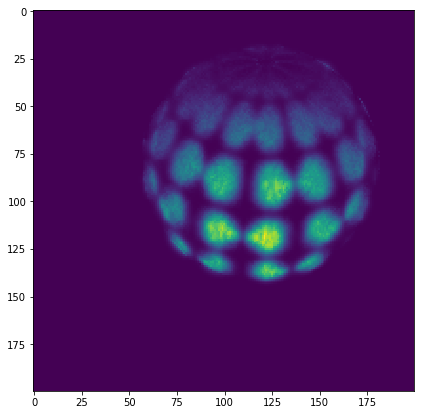

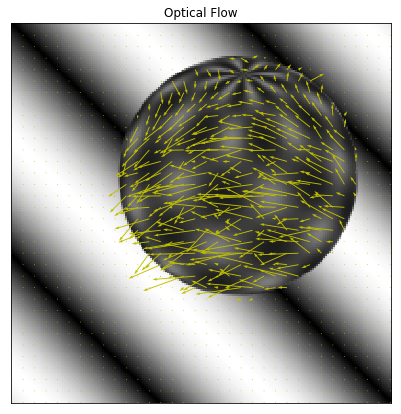

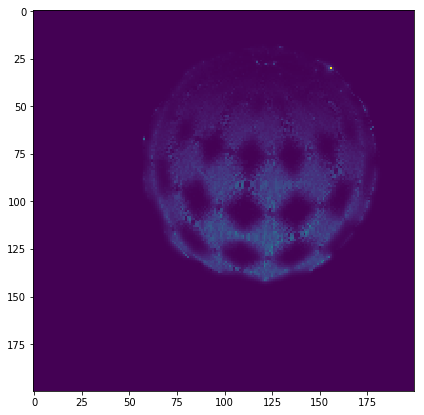

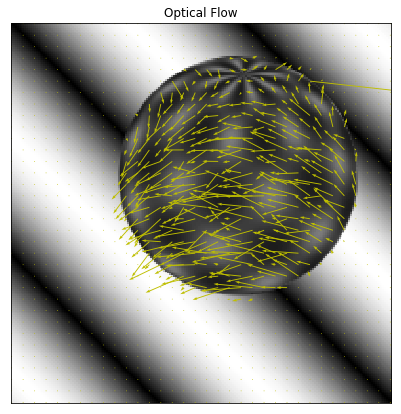

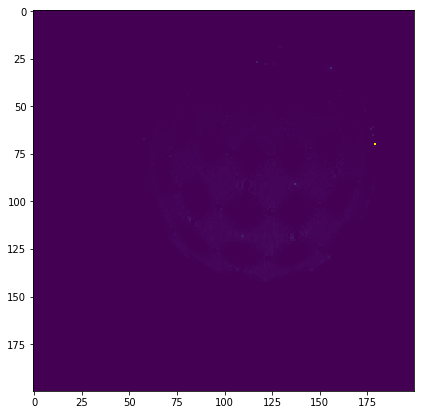

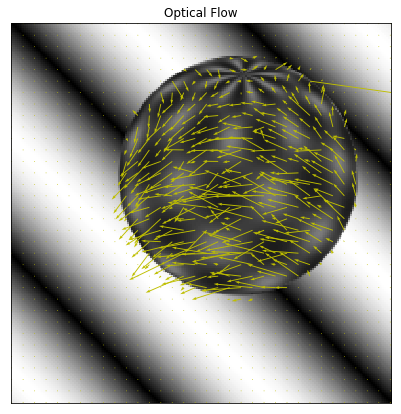

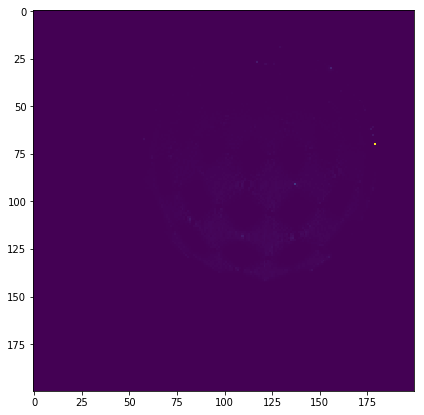

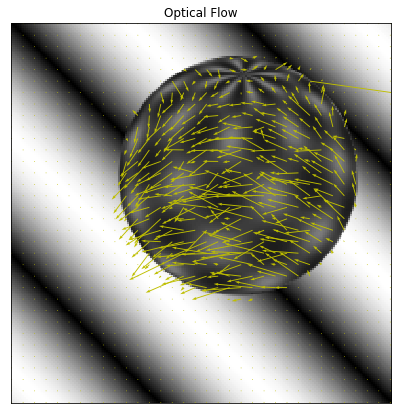

In [41]:
for alpha in [100,10,1,0.1]:
    print('Horn Schunck for alpha: ',alpha)
    U,V = horn_schunck(sphere1,sphere2,alpha=alpha,iter_=20)
    create_quiver_plot(U,V,sphere1,subsample=6)
    print('***'*10)

Horn Schunck for alpha:  5000
******************************
Horn Schunck for alpha:  4000
******************************
Horn Schunck for alpha:  3000
******************************
Horn Schunck for alpha:  1000
******************************
Horn Schunck for alpha:  500
******************************
Horn Schunck for alpha:  200
******************************


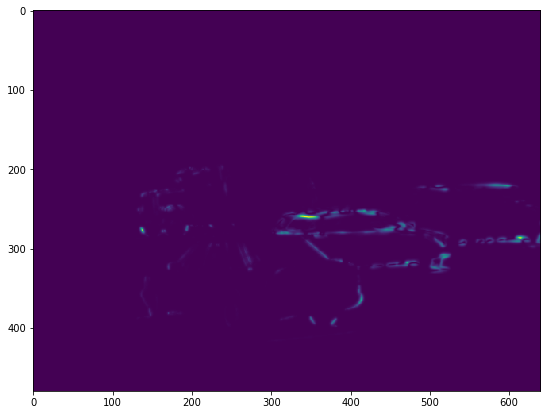

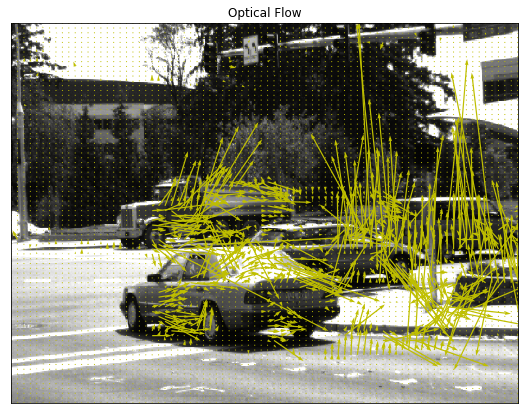

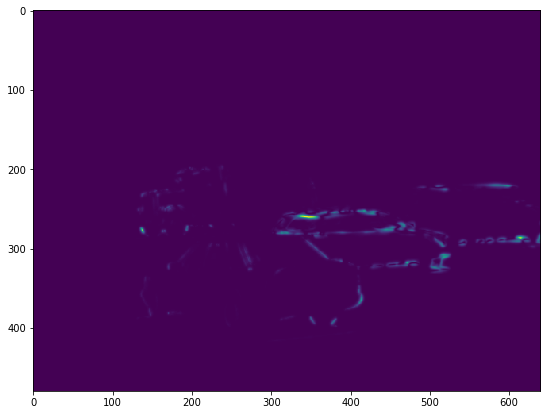

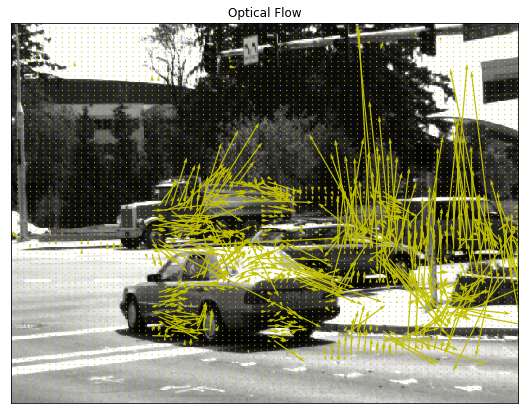

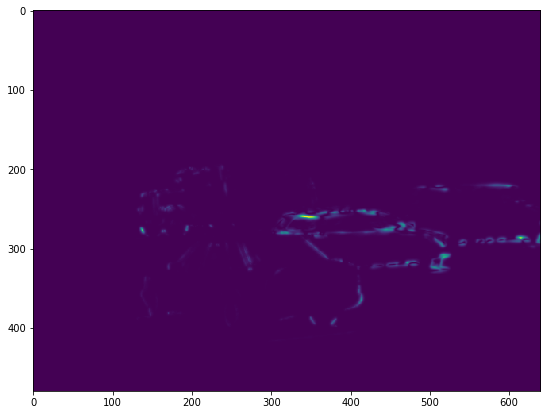

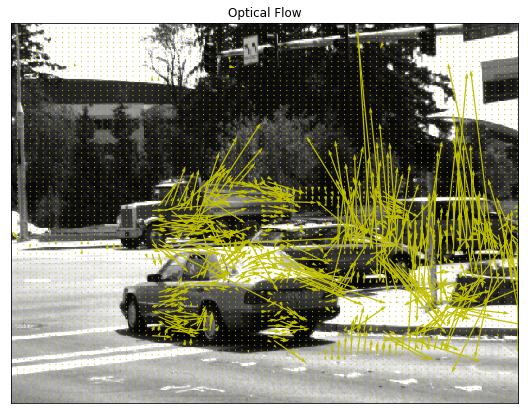

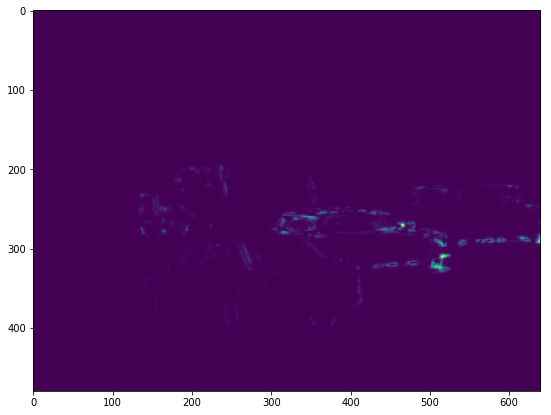

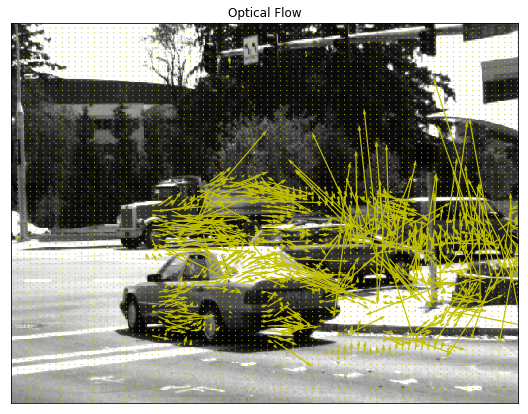

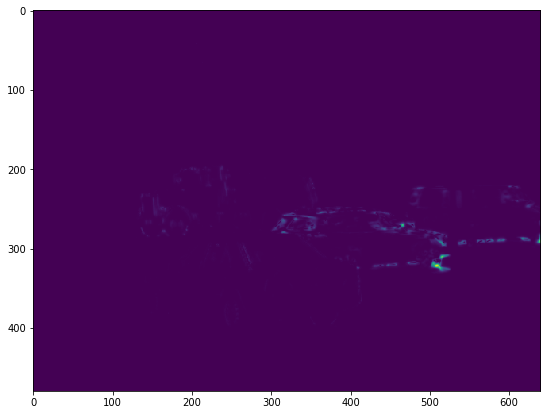

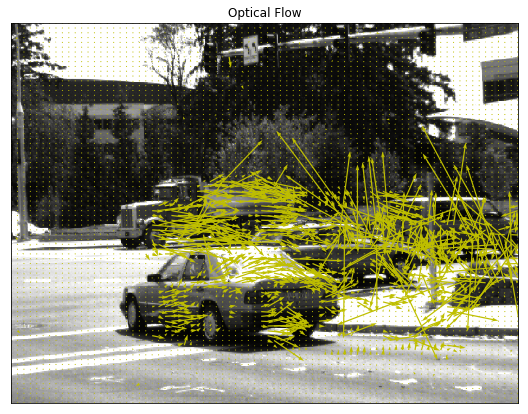

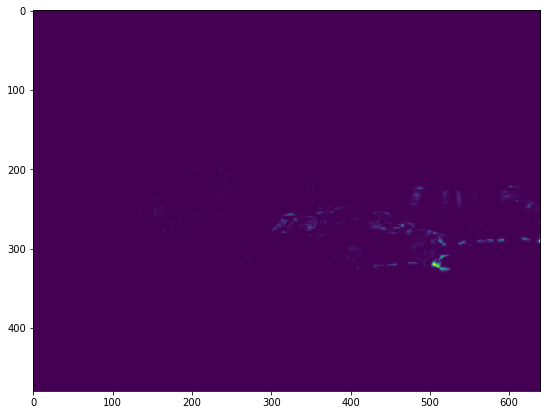

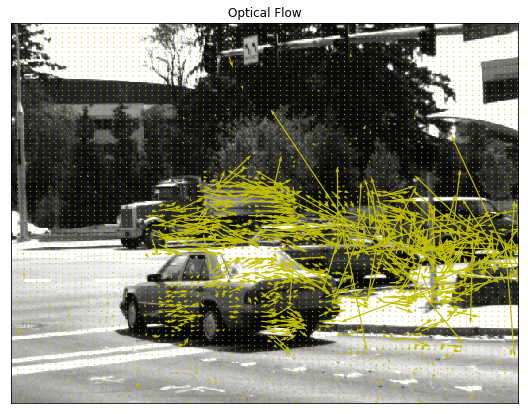

In [11]:
for alpha in [5000,4000,3000,1000,500,200]:
    print('Horn Schunck for alpha: ',alpha)
    U,V = horn_schunck(traffic1,traffic2,iter_=20,alpha=alpha)
    create_quiver_plot(U,V,traffic1)
    print('***'*10)